# Covid forecasting

## Setup
Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import datetime

keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# functions to generate random time series for experimentation
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
    
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
df = pd.read_csv('/content/Hospitalizaciones_Dia_upt_2020_2021.csv')

In [ ]:
df = df.dropna()
df.head

<bound method NDFrame.head of      CountFI FECHA_INGRESO
0          3    2020-01-01
1          5    2020-01-05
2          7    2020-01-06
3          4    2020-01-07
4         11    2020-01-08
..       ...           ...
630    17042    2021-09-27
631    12334    2021-09-28
632     9862    2021-09-29
633     4756    2021-09-30
634       34    2021-10-01

[635 rows x 2 columns]>

In [ ]:
df['FECHA_INGRESO'] = pd.to_datetime(df['FECHA_INGRESO'], format='%Y/%m/%d')

In [ ]:
df.dtypes

CountFI                   int64
FECHA_INGRESO    datetime64[ns]
dtype: object

In [ ]:
df = df.set_index('FECHA_INGRESO')

In [ ]:
#time = df["FECHA_INGRESO"].to_numpy()
time = df.index.values

In [ ]:
time.dtype

dtype('<M8[ns]')

In [ ]:
#print(time)

In [ ]:
print(time[545])

2021-07-04T00:00:00.000000000


## Plot Graph

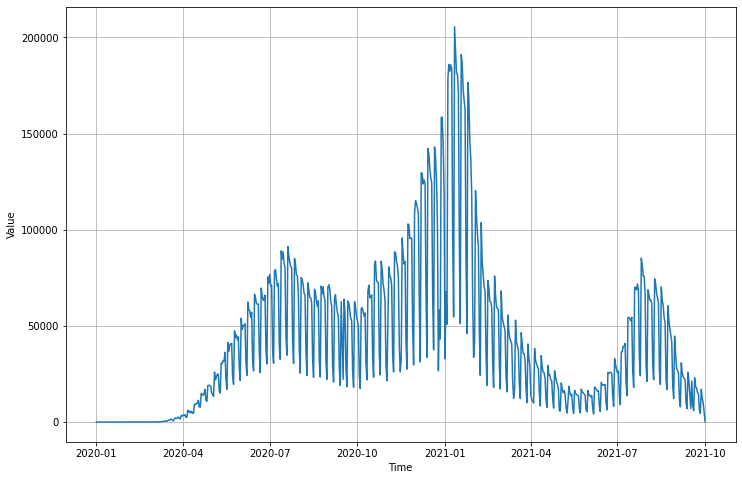

In [ ]:
series = df.to_numpy()
#series = df["CountDEF"].to_numpy()

plt.figure(figsize=(12, 8))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 480
split_time_pred = 545
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Scale data

In [ ]:
scaler = MinMaxScaler()

#.reshape(-1,1)
x_train = scaler.fit_transform(x_train.reshape(-1,1))
x_valid = scaler.fit_transform(x_valid.reshape(-1,1))

Compute best learning rate for the model

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 4
#train_set = seq2seq_window_dataset(x_train, window_size, batch_size=8)
train_set = TimeseriesGenerator(x_train, x_train, length = window_size, batch_size=1)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
476/476 [==============================] - 49s 32ms/step - loss: 0.0252 - mae: 0.1639 - lr: 1.0000e-04
Epoch 2/100
476/476 [==============================] - 10s 21ms/step - loss: 0.0133 - mae: 0.1258 - lr: 1.0798e-04
Epoch 3/100
476/476 [==============================] - 18s 37ms/step - loss: 0.0110 - mae: 0.1065 - lr: 1.1659e-04
Epoch 4/100
476/476 [==============================] - 10s 21ms/step - loss: 0.0104 - mae: 0.1005 - lr: 1.2589e-04
Epoch 5/100
476/476 [==============================] - 14s 28ms/step - loss: 0.0101 - mae: 0.0968 - lr: 1.3594e-04
Epoch 6/100
476/476 [==============================] - 12s 26ms/step - loss: 0.0101 - mae: 0.0962 - lr: 1.4678e-04
Epoch 7/100
476/476 [==============================] - 17s 36ms/step - loss: 0.0100 - mae: 0.0953 - lr: 1.5849e-04
Epoch 8/100
476/476 [==============================] - 19s 40ms/step - loss: 0.0098 - mae: 0.0945 - lr: 1.7113e-04
Epoch 9/100
476/476 [==============================] - 14s 29ms/step - loss: 0.0

(0.0001, 0.1, 0.0, 0.1)

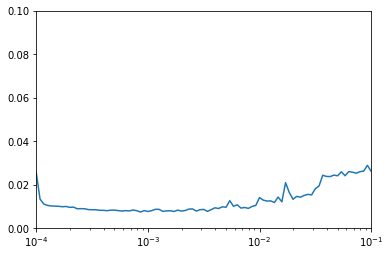

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .1])

Train model

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 5
#train_set = seq2seq_window_dataset(x_train, window_size, batch_size=8)
#valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=8)
train_set = TimeseriesGenerator(x_train, x_train, length = window_size, batch_size=1)
valid_set = TimeseriesGenerator(x_valid, x_valid, length = window_size, batch_size=1)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Dropout(0.2))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=2e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpointCases.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=30)
history = model.fit(train_set, epochs=300,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300
475/475 [==============================] - 37s 52ms/step - loss: 0.0440 - mae: 0.2165 - val_loss: 0.0707 - val_mae: 0.2811
Epoch 2/300
475/475 [==============================] - 25s 52ms/step - loss: 0.0325 - mae: 0.1819 - val_loss: 0.0508 - val_mae: 0.2204
Epoch 3/300
475/475 [==============================] - 22s 46ms/step - loss: 0.0232 - mae: 0.1561 - val_loss: 0.0371 - val_mae: 0.1823
Epoch 4/300
475/475 [==============================] - 28s 59ms/step - loss: 0.0194 - mae: 0.1507 - val_loss: 0.0310 - val_mae: 0.1733
Epoch 5/300
475/475 [==============================] - 24s 51ms/step - loss: 0.0181 - mae: 0.1486 - val_loss: 0.0288 - val_mae: 0.1700
Epoch 6/300
475/475 [==============================] - 25s 52ms/step - loss: 0.0173 - mae: 0.1452 - val_loss: 0.0269 - val_mae: 0.1669
Epoch 7/300
475/475 [==============================] - 28s 59ms/step - loss: 0.0159 - mae: 0.1404 - val_loss: 0.0260 - val_mae: 0.1634
Epoch 8/300
475/475 [==============================] - 

In [ ]:
model = keras.models.load_model("my_checkpointCases.h5")

Make predictions

In [ ]:
days = 90

In [ ]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - (1):-1, 0]

In [ ]:
rnn_forecastFuture = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecastFuture = rnn_forecastFuture[0, split_time - (1+days):-1, 0]

In [ ]:
rnn_forecastFuture1 = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecastFuture1 = rnn_forecastFuture1[0, split_time_pred - (1+days):-1, 0]

In [ ]:
time_valid1 = pd.DataFrame(time_valid, columns = ['Fecha'])
time_valid1

,Fecha
0,2021-04-30
1,2021-05-01
2,2021-05-02
3,2021-05-03
4,2021-05-04
...,...
150,2021-09-27
151,2021-09-28
152,2021-09-29
153,2021-09-30


In [ ]:
last_date = time_valid1["Fecha"].iloc[-1]

#date_1 = datetime.datetime.strptime(start_date, "%m/%d/%y")   split_time - days
#end_date = date_1 + datetime.timedelta(days=10)
for i in range(days):
  last_date = last_date + datetime.timedelta(days=1)
  time_valid1 = time_valid1.append({'Fecha': last_date}, ignore_index=True)
time_valid1 = time_valid1.to_numpy().reshape(-1)


In [ ]:
time_valid_pred = time[split_time_pred:]

In [ ]:
time_valid_pred = pd.DataFrame(time_valid_pred, columns = ['Fecha'])
time_valid_pred

,Fecha
0,2021-07-04
1,2021-07-05
2,2021-07-06
3,2021-07-07
4,2021-07-08
...,...
85,2021-09-27
86,2021-09-28
87,2021-09-29
88,2021-09-30


In [ ]:
last_date_pred = time_valid_pred["Fecha"].iloc[-1]

#date_1 = datetime.datetime.strptime(start_date, "%m/%d/%y")   split_time - days
#end_date = date_1 + datetime.timedelta(days=10)
for i in range(days):
  last_date_pred = last_date_pred + datetime.timedelta(days=1)
  time_valid_pred = time_valid_pred.append({'Fecha': last_date_pred}, ignore_index=True)
time_valid_pred = time_valid_pred.to_numpy().reshape(-1)

Plot predictions

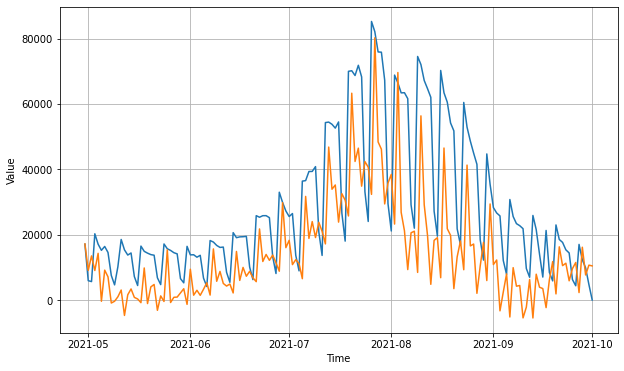

In [ ]:
#plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaler.inverse_transform(x_valid))
#plot_series(time_valid, np.absolute(lin_forecast))
plt.figure(figsize=(10, 6))
plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid, rnn_forecast)

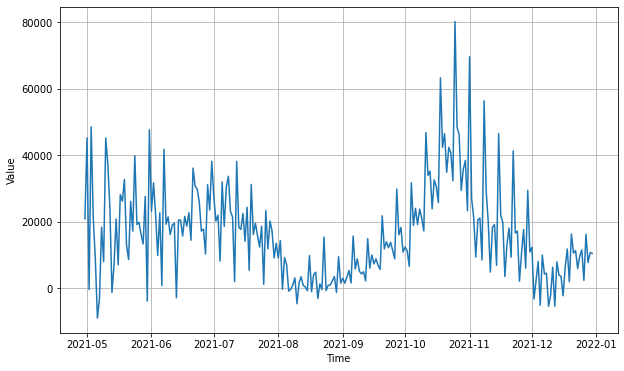

In [ ]:
plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid1, rnn_forecastFuture)

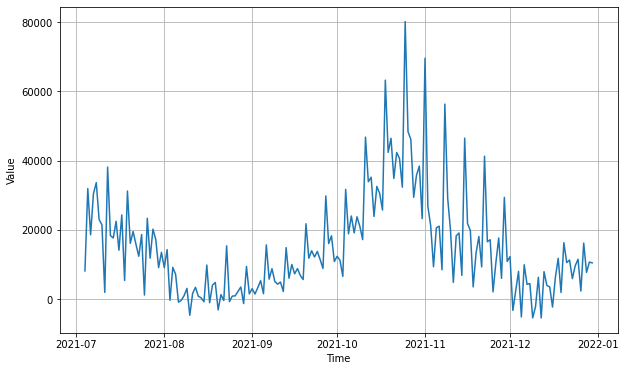

In [ ]:
plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid_pred, rnn_forecastFuture1)